In [ ]:
#Load all libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time
import joblib


# Set display options for pandas
display_options = {
    'display.max_columns': None,
    'display.width': 1000,
}
for option, value in display_options.items():
    pd.set_option(option, value)

# Set seaborn style for visualization
sns.set_style("darkgrid")

# Check TensorFlow and Keras versions
# Check TensorFlow and Keras versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.version.VERSION)


TensorFlow version: 2.18.0
Keras version: 2.18.0


In [ ]:
# Load dataset
# Step 2: Load the phishing website dataset
dataset_path = "/content/dataset_full.csv"
data = pd.read_csv(dataset_path)

# Display basic information about the dataset
print("Dataset loaded successfully!")
print("Dataset shape:", data.shape)
print("First five rows:")
print(data.head())

Dataset loaded successfully!
Dataset shape: (88647, 112)
First five rows:
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url  qty_tld_url  length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_

In [ ]:
# Step 3: Preprocess the dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Handle missing values
data = data.dropna()

# Remove duplicate rows
data = data.drop_duplicates()

# Convert boolean features to integer
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

# Identify numerical columns
numerical_columns = [col for col in data.columns if col not in boolean_columns]

# Standardize numerical features using StandardScaler
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])

# Normalize numerical features using MinMaxScaler
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

 #Save scalers for later use in real-time predictions
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")

# Save the cleaned dataset as newphishdata.csv
cleaned_dataset_path = "newphishdata.csv"
data.to_csv(cleaned_dataset_path, index=False)

print("Dataset preprocessing completed. Cleaned dataset saved as", cleaned_dataset_path)



<ipython-input-10-7d3f6ad78fa7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[boolean_columns] = data[boolean_columns].astype(int)


Dataset preprocessing completed. Cleaned dataset saved as newphishdata.csv



Summary Statistics:
        qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  qty_questionmark_url  qty_equal_url    qty_at_url   qty_and_url  qty_exclamation_url  qty_space_url  qty_tilde_url  qty_comma_url  qty_plus_url  qty_asterisk_url  qty_hashtag_url  qty_dollar_url  qty_percent_url   qty_tld_url    length_url  qty_dot_domain  qty_hyphen_domain  qty_underline_domain  qty_slash_domain  qty_questionmark_domain  qty_equal_domain  qty_at_domain  qty_and_domain  qty_exclamation_domain  qty_space_domain  qty_tilde_domain  qty_comma_domain  qty_plus_domain  qty_asterisk_domain  qty_hashtag_domain  qty_dollar_domain  qty_percent_domain  qty_vowels_domain  domain_length  domain_in_ip  server_client_domain  qty_dot_directory  qty_hyphen_directory  qty_underline_directory  qty_slash_directory  qty_questionmark_directory  qty_equal_directory  qty_at_directory  qty_and_directory  qty_exclamation_directory  qty_space_directory  qty_tilde_directory  qty_comma_directory  qty_plus_d

<ipython-input-11-69696e36bbf0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='phishing', data=data, palette='coolwarm')


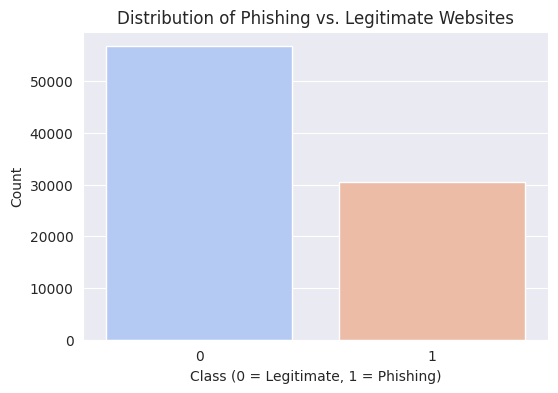

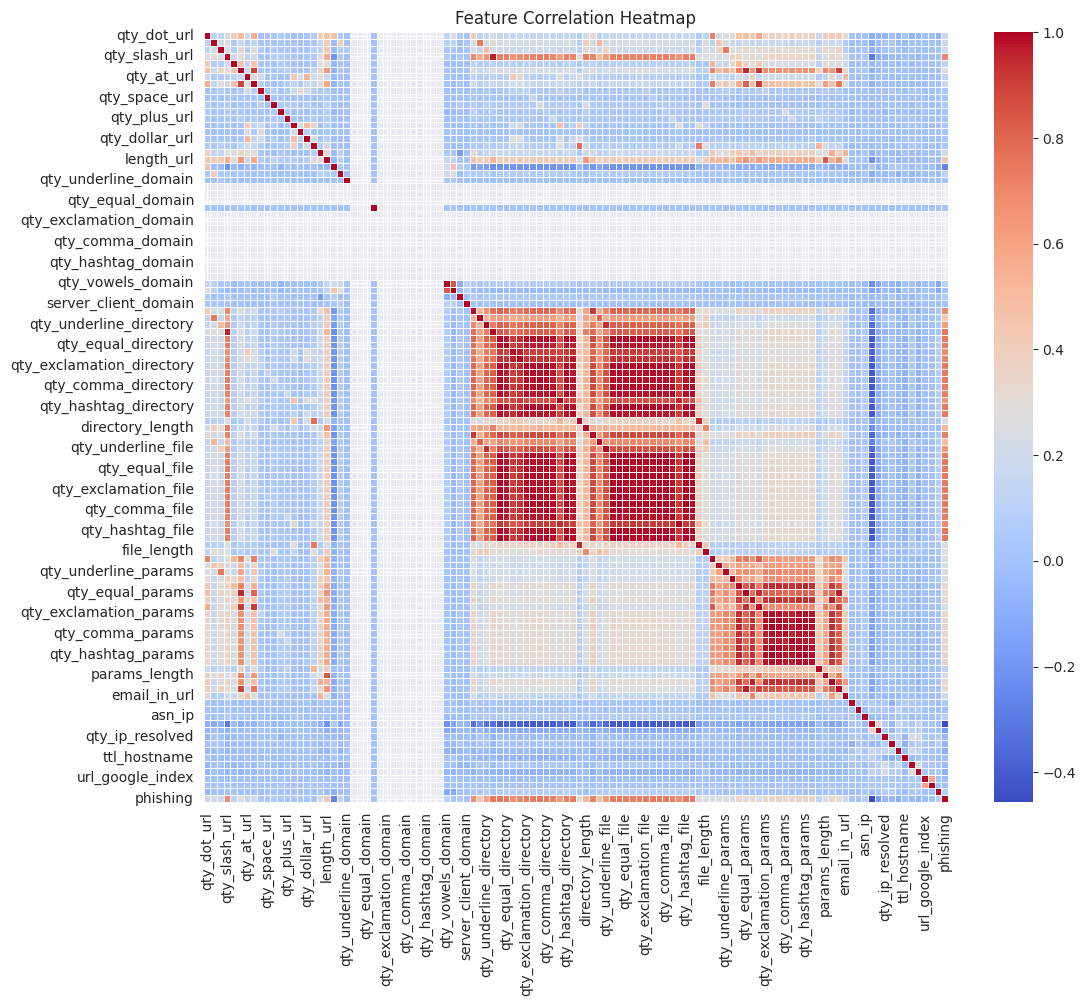

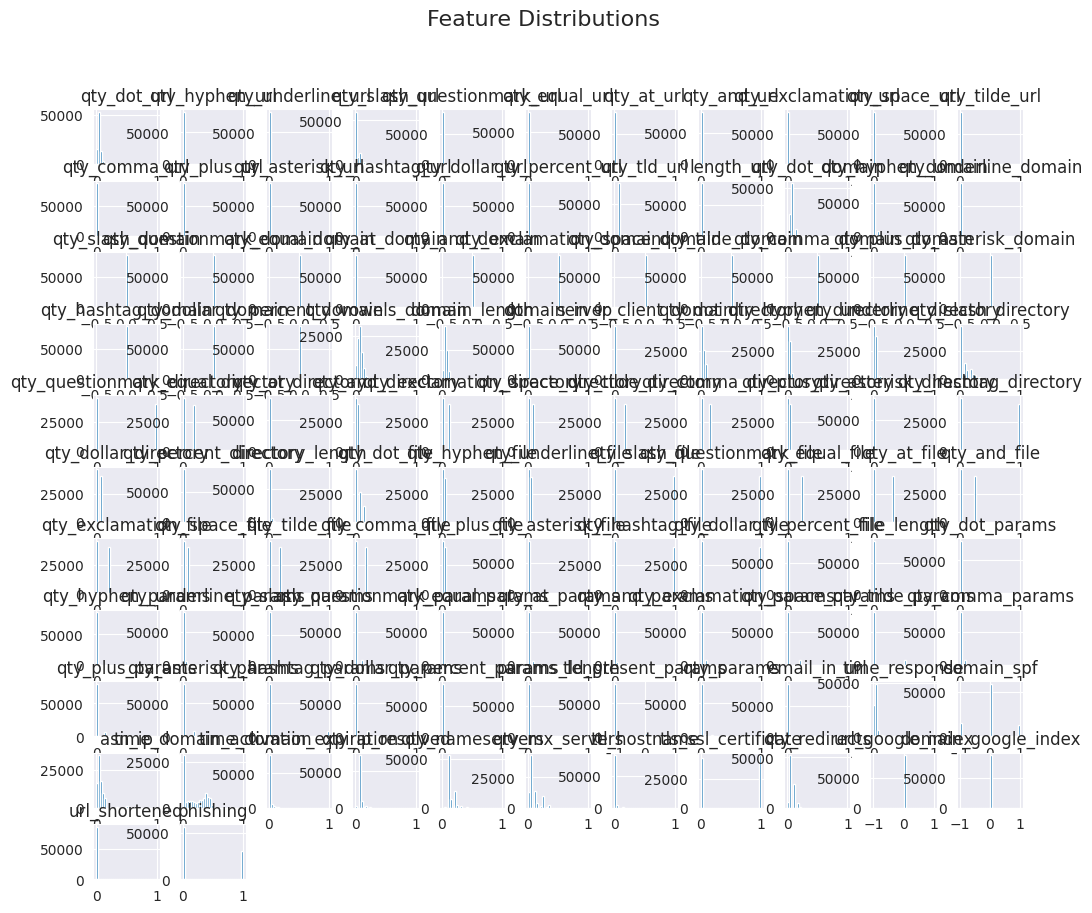

In [ ]:
# Step 4: Exploratory Data Analysis (EDA)
# Display summary statistics
print("\nSummary Statistics:")
print(data.describe())

# Plot distribution of phishing vs. legitimate websites
plt.figure(figsize=(6,4))
sns.countplot(x='phishing', data=data, palette='coolwarm')
plt.title("Distribution of Phishing vs. Legitimate Websites")
plt.xlabel("Class (0 = Legitimate, 1 = Phishing)")
plt.ylabel("Count")
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Visualize feature distributions
data.hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

In [ ]:
# Step 5: Split the dataset into training (80%) and testing (20%) sets
X = data.drop(columns=['phishing'])  # Features
y = data['phishing']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dataset successfully split into training and testing sets.")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Dataset successfully split into training and testing sets.
Training set shape: (69767, 111)
Testing set shape: (17442, 111)


In [ ]:
from tensorflow.keras.layers import LSTM, Conv1D, Flatten, BatchNormalization

# Reshape the data for LSTM and CNN compatibility
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM + CNN hybrid model
model = Sequential()

# LSTM layer
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# CNN layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC'],
    jit_compile=True
)

# Model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,    # reduced epochs size , batch size =32
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

print("LSTM + CNN Model training complete.")



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 111, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 111, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 111, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 111, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 111, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3552)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         454,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 486,305 (1.86 MB)

 Trainable params: 486,241 (1.85 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 166s 147ms/step - AUC: 0.9454 - Precision: 0.7927 - Recall: 0.9027 - accuracy: 0.8821 - loss: 0.2679 - val_AUC: 0.9786 - val_Precision: 0.8688 - val_Recall: 0.9297 - val_accuracy: 0.9263 - val_loss: 0.1784
Epoch 2/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 193s 141ms/step - AUC: 0.9719 - Precision: 0.8539 - Recall: 0.9067 - accuracy: 0.9131 - loss: 0.2016 - val_AUC: 0.9801 - val_Precision: 0.8742 - val_Recall: 0.9124 - val_accuracy: 0.9235 - val_loss: 0.1787
Epoch 3/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 202s 141ms/step - AUC: 0.9756 - Precision: 0.8707 - Recall: 0.9090 - accuracy: 0.9211 - loss: 0.1891 - val_AUC: 0.9826 - val_Precision: 0.8421 - val_Recall: 0.9556 - val_accuracy: 0.9218 - val_loss: 0.1689
Epoch 4/20
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 202s 141ms/step - AUC: 0.9775 - Precision: 0.8770 - Recall: 0.9130 - accuracy: 0.9250 - loss: 0.1815 - val_AUC: 0.9838 - val_Precision: 0.9066 - val_Recall: 0.9116 - val_accuracy: 0.9362 - val_loss: 0.1581
Epoch 5/

In [ ]:
# Step 8: Generate Predictions & Evaluate the Model
# Generate predictions
y_pred_lstm_cnn = (model.predict(X_test) > 0.5).astype(int)

# Compute evaluation metrics
accuracy_lstm_cnn = accuracy_score(y_test, y_pred_lstm_cnn)
precision_lstm_cnn = precision_score(y_test, y_pred_lstm_cnn)
recall_lstm_cnn = recall_score(y_test, y_pred_lstm_cnn)
auc_lstm_cnn = roc_auc_score(y_test, y_pred_lstm_cnn)
conf_matrix_lstm_cnn = confusion_matrix(y_test, y_pred_lstm_cnn)

# Display results
print("\nLSTM + CNN Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_lstm_cnn:.4f}")
print(f"Precision: {precision_lstm_cnn:.4f}")
print(f"Recall: {recall_lstm_cnn:.4f}")
print(f"AUC Score: {auc_lstm_cnn:.4f}")
print("Confusion Matrix:")
print(conf_matrix_lstm_cnn)


546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step

LSTM + CNN Model Evaluation Metrics:
Accuracy: 0.9515
Precision: 0.9294
Recall: 0.9321
AUC Score: 0.9470
Confusion Matrix:
[[10911   432]
 [  414  5685]]


In [ ]:
# Step 9: Compute False Acceptance Rate (FAR) and False Rejection Rate (FRR)
# Extract values from the confusion matrix
false_positives_lstm_cnn = conf_matrix_lstm_cnn[0][1]
false_negatives_lstm_cnn = conf_matrix_lstm_cnn[1][0]
true_negatives_lstm_cnn = conf_matrix_lstm_cnn[0][0]
true_positives_lstm_cnn = conf_matrix_lstm_cnn[1][1]

# Compute FAR and FRR
far_lstm_cnn = false_positives_lstm_cnn / (false_positives_lstm_cnn + true_negatives_lstm_cnn)
frr_lstm_cnn = false_negatives_lstm_cnn / (false_negatives_lstm_cnn + true_positives_lstm_cnn)

# Display FAR and FRR
print("\nFalse Acceptance Rate (FAR):", round(far_lstm_cnn, 4))
print("False Rejection Rate (FRR):", round(frr_lstm_cnn, 4))



False Acceptance Rate (FAR): 0.0381
False Rejection Rate (FRR): 0.0679


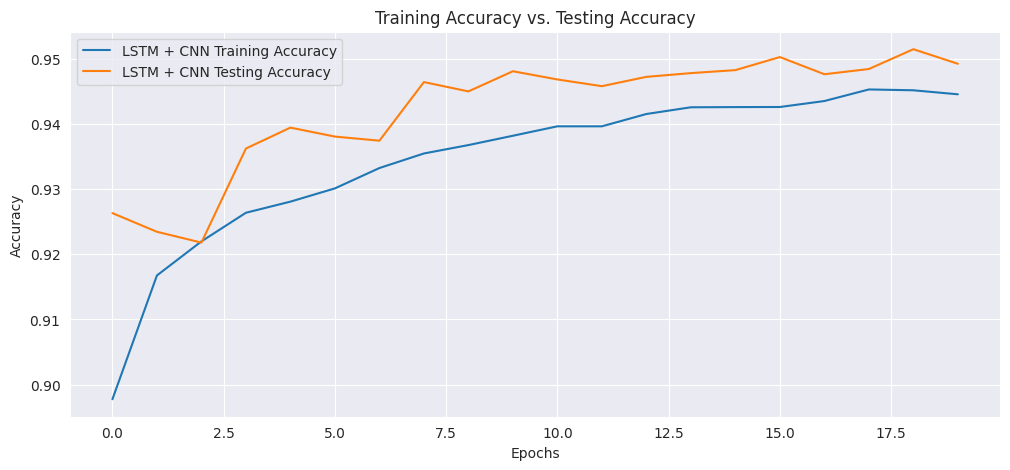

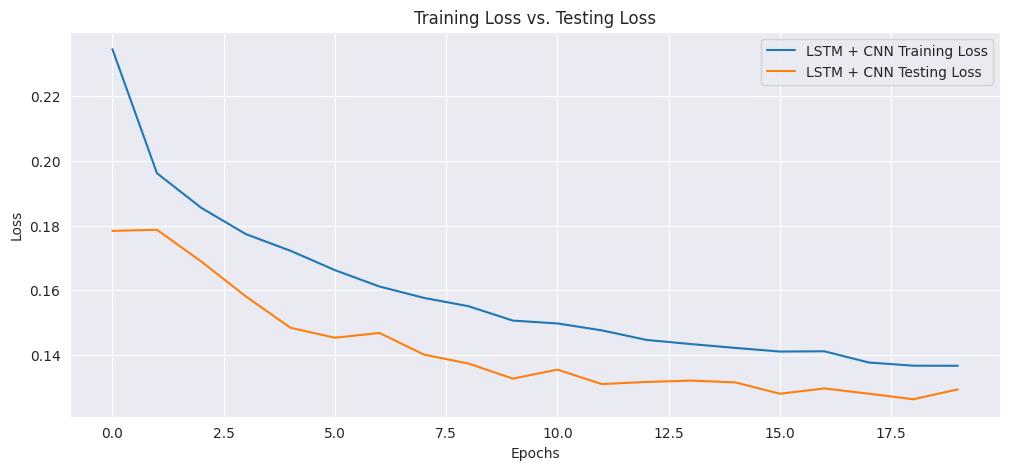

In [ ]:

# Step 10: Plot Training Accuracy & Loss
# Save training history
np.save("model_history_LSTM_CNN.npy", history.history)
hist_lstm_cnn = np.load("model_history_LSTM_CNN.npy", allow_pickle=True).item()

# Plot Training Accuracy vs. Testing Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='LSTM + CNN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='LSTM + CNN Testing Accuracy')
plt.title("Training Accuracy vs. Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Training Loss vs. Testing Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='LSTM + CNN Training Loss')
plt.plot(history.history['val_loss'], label='LSTM + CNN Testing Loss')
plt.title("Training Loss vs. Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
